# Analyzing Maryland's Regional Disparities in Birth Rate and Income

## Introduction

### Importance of Analyzing Birth Rate and Income
Birth rates provide insight to trends important to all aspects of society. Educational needs, future workforce potential, health care quality, and several other aspects, allows us to predict which direction our future generation is headed. The insights we gain from analyzing income, including poverty rates and overall living standards, descibe our ability to adequately care for the next genrations. Determining the correlation between income and birth rates allows policy makers and government leaders to make the apporiate investments in the right places. For example, places with high birth rates and low houshold incomes, may indicate lack of education, the unaffordability of contraceptives, and high infant mortality. Conversely, low birthrates and high household income may indicate aging poulations and high levels of infertility. Understanding this data allows policy makers and government officals to provide adequate aid and make the proper investments in the correct places. Taking these steps in at local, state, and national levels are for the betterment of the nation and our society.


### Motivation
Maryland's twenty-three diverse counties each contribute uniquely to the state's rich tapestry. While we celebrate the variety among Maryland's communities, it is equally important to analyze how these differences impact residents both positively and negatively.

This project aims to utilize the Data Science Pipeline to thoroughly examine the disparities in household income and birthrate across Maryland's counties. Understanding these disparities is crucial for developing effective policies and practices that can enhance the quality of life in each county. By uncovering the presence, or absence, of a correlation between household income and birthrates, our analysis will provide valuable insights.

Our findings have the potential to spark further research into the socio-economic factors influencing median income and birthrate. This deeper investigation could lead to a better understanding of the underlying dynamics and inform targeted interventions to address regional inequities. Ultimately, our goal is to contribute to a more equitable and prosperous future for all communities within Maryland.

In [21]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from io import StringIO


import requests

## Data Collection:

The first stage of the Data Science Life Cycle is data collection. To determine correlation between median houseshold income and birth rate, we must locate and standardize alll datasets related to our topic. [The Maryland Open Data Portal](https://opendata.maryland.gov/) (MODP) provides access to statewide statistical data national census information relating to the state of Maryland. Datasets from The Maryland Open Data Portal have been verificed by the state, but are subject to change with time.

Using the "Request" Python library, we are able to access the information given by the MODP's API's. Here, we can access annual median income, population, and birth rate statistics for each county in Maryland. To prevent data skewing, we have selected a sample range consistent with each dataset. By selecting data from 2010 - 2022 in each data range, we are able to determine correlation betweeen birth rate and annual income over 12-year period.

During this project, we used the programming language Python. The language's extensive libraries allowed for easy data collection, visualization, and representation.

In [22]:
# # Access Maryland's "Open Data Portal" and Median County Income, Population, and Birth Rate Data (2010 - 2022)
# county_income = pd.read_csv("https://opendata.maryland.gov/resource/bvk4-qsxs.csv")
# county_population = pd.read_csv("https://opendata.maryland.gov/resource/r7ky-rq9s.csv")
# maryland_birthrate = pd.read_csv("https://opendata.maryland.gov/resource/vavn-j725.csv")


In [23]:
income_url = "https://opendata.maryland.gov/resource/bvk4-qsxs.csv"
population_url = "https://opendata.maryland.gov/resource/r7ky-rq9s.csv"
birthrate_url = "https://opendata.maryland.gov/resource/vavn-j725.csv"

# Function to download CSV from URL
def download_csv(url):
    response = requests.get(url)
    response.raise_for_status()  # Check that the request was successful
    return pd.read_csv(StringIO(response.text))

# Download and load the datasets
county_income = download_csv(income_url)
county_population = download_csv(population_url)
maryland_birthrate = download_csv(birthrate_url)


The "Pandas" Python library allows us to the next step in the Data Science Process: data preprocessing. In order to later manipulate the data and accurately represent the collected information, we must correct and remove all inconsistencies between the datasets. This standardization process allows us to create a consistent flow of information. 

Here we used pandas dataframes. These objects were able to convert the datasets (entered as Comma-Seperated Values) into tables that could be accessed and transformed.

Although the information provided by the Maryland Open Data Portal has had its accuracy verified, when the data was first accessed, it was severely untidy. Counties were represented as column variables, instead of having each row represent an instance of the dataset. This organizaton of data violates the "Tidy Data" convention.

In [24]:
# Removing Duplicate Rows in Dataframes
median_household_income = county_income[22:]

# Dropping Unnecessary Data
median_household_income = median_household_income[median_household_income["data"] != "MOE"]
median_household_income = median_household_income.drop(["date_created", "data", "maryland"], axis=1)

maryland_birthrate = maryland_birthrate.drop(["date_created", "maryland"], axis=1)

county_population = county_population.drop_duplicates()
county_population = county_population.drop(["date_created", "maryland"], axis=1)

In [25]:
# Standardizing Row Names
column_names = ["Year",  
"Allegany County", 
"Anne Arundel County", 
"Baltimore County", 
"Baltimore City",
"Calvert County",
"Caroline County",
"Carroll County",
"Cecil County",
"Charles County",
"Dorchester County",
"Frederick County",
"Garrett County",
"Harford County",
"Howard County",
"Kent County",
"Montgomery County",
"Prince George's County",
"Queen Anne's County",
"St. Mary's County",
"Somerset County",
"Talbot County",
"Washington County",
"Wicomico County",
"Worcester County"]

# Renaming Columns
median_household_income.columns = column_names
maryland_birthrate.columns = column_names
county_population.columns = column_names

# Melting Data and Representing Counties as Row Values
median_household_income = median_household_income.melt(id_vars=['Year'], var_name='County', value_name='Median Income')
maryland_birthrate = maryland_birthrate.melt(id_vars=['Year'], var_name='County', value_name='Total Births')
county_population =  county_population.melt(id_vars=['Year'], var_name='County', value_name='Annual Population')

# Combining Dataframes
annual_income_and_birthrate = pd.merge(median_household_income, maryland_birthrate, on=["Year", "County"])
annual_income_and_birthrate = pd.merge(annual_income_and_birthrate, county_population, on=["Year", "County"])

# Normalizing Number of Births by Population Size (Birth Rate per 1000 people)
annual_income_and_birthrate["Annual Birth Rate Per 1000"] = (maryland_birthrate["Total Births"] / county_population["Annual Population"])  * 1000
annual_income_and_birthrate.head()

,Year,County,Median Income,Total Births,Annual Population,Annual Birth Rate Per 1000
0,2010,Allegany County,37083,735,74965,9.804575
1,2011,Allegany County,38504,703,74572,9.427131
2,2012,Allegany County,38670,674,73947,9.114636
3,2013,Allegany County,39994,676,73576,9.187779
4,2014,Allegany County,39808,709,73020,9.709669
...,...,...,...,...,...,...
307,2018,Worcester County,59266,414,51960,7.967667
308,2019,Worcester County,65821,393,52276,7.517790
309,2020,Worcester County,62481,409,52261,7.826104
310,2021,Worcester County,70952,393,53132,7.396672


## Exploratory Data Analysis:

### Goal: To Visualize Data and Determine the Presence of Trends

In this section of the Data Science Pipeline, we need to visualize data in order to identify potential trends between variables. It is here were we identify the existence, or absense, of trends between the tested independent and dependent variables. Our data analysis began with indentifying missing or irrelevant values that would impact the trends we see. Since Maryland's Open Data Portal is responsible for collecting the data used in decision and policy making within the state, there were very few instance of missing data. However, each data set contained duplicate rows. We were able to remove these duplicates using the Pandas Library's drop() function.


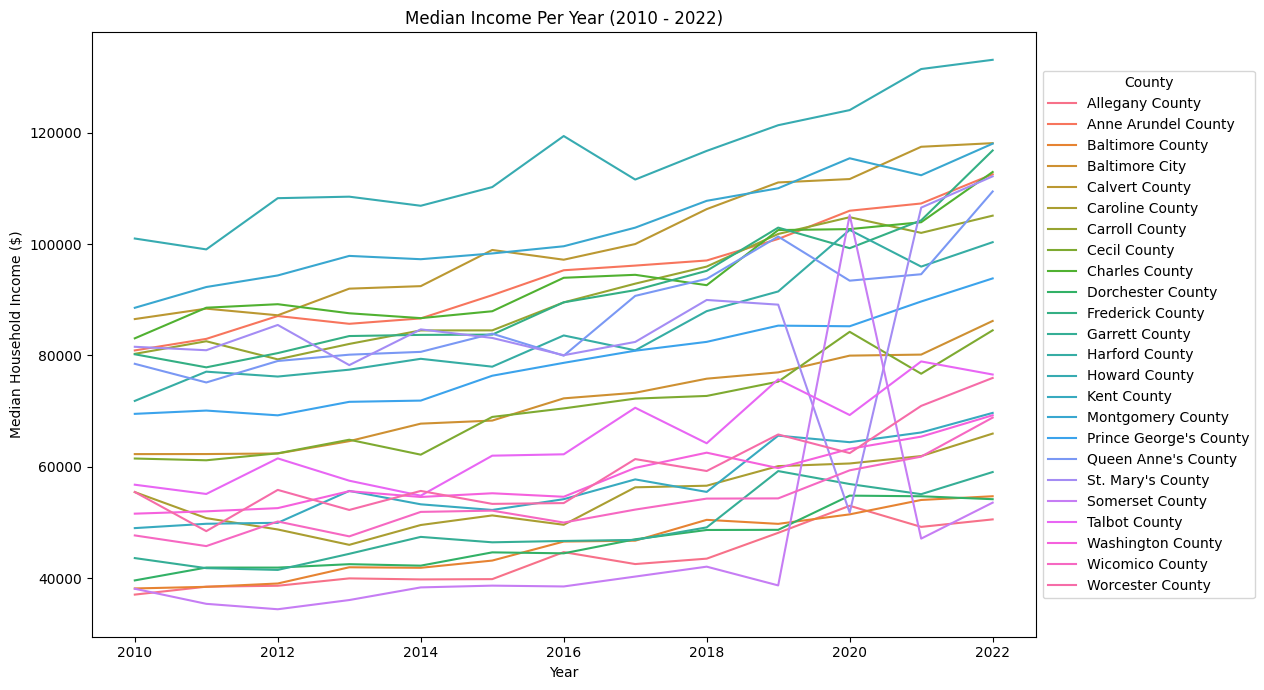

In [26]:
# Median Income Per Year
plt.figure(figsize=(15, 7))
sb.lineplot(data=annual_income_and_birthrate, x="Year", y= "Median Income", hue= "County")

plt.xlabel("Year")
plt.ylabel('Median Household Income ($)')
plt.title("Median Income Per Year (2010 - 2022)")
plt.legend(loc= "center left", bbox_to_anchor=(1, 0.5), title= "County")
plt.tight_layout(rect=[0, 0, 0.85, 1])



The previous graph is a representation of the change in each county's median household income. It can be observed that as time progresses, most counties experience a linear increase in household income per year. The two larges outliers in this data come from Queen Anne's County and Somerset County. Both of these counties experience a steep rate of change over a two-year period (2019 - 2021). The most obvious explanation for the repective increases and decreases, is the Covid-19 pandemic period. 

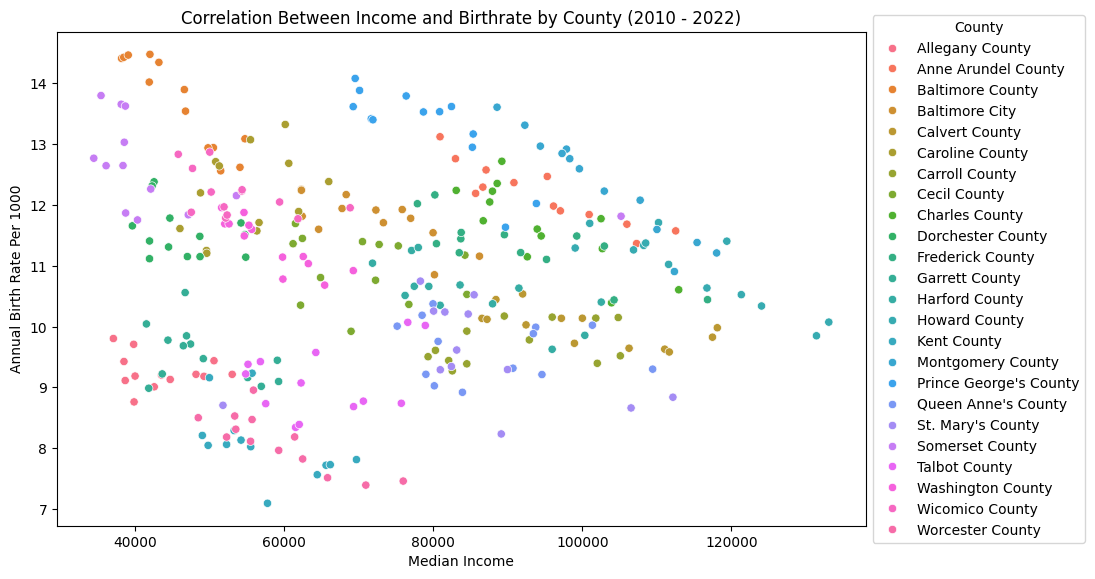

In [27]:
# Birth Trends Per Annual Income
plt.figure(figsize=(13, 6))
sb.scatterplot(data=annual_income_and_birthrate, x="Median Income", y= "Annual Birth Rate Per 1000", hue="County")
plt.title('Correlation Between Income and Birthrate by County (2010 - 2022)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="County")
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In the graph above "Correlation Betwen Income and Birthrate by County (2010 - 2022)", we observe that there is no single trend line that all Maryland Counties follow. However, we do notice, that each indivual counties' data appear to have a mostly linear trend over time. A

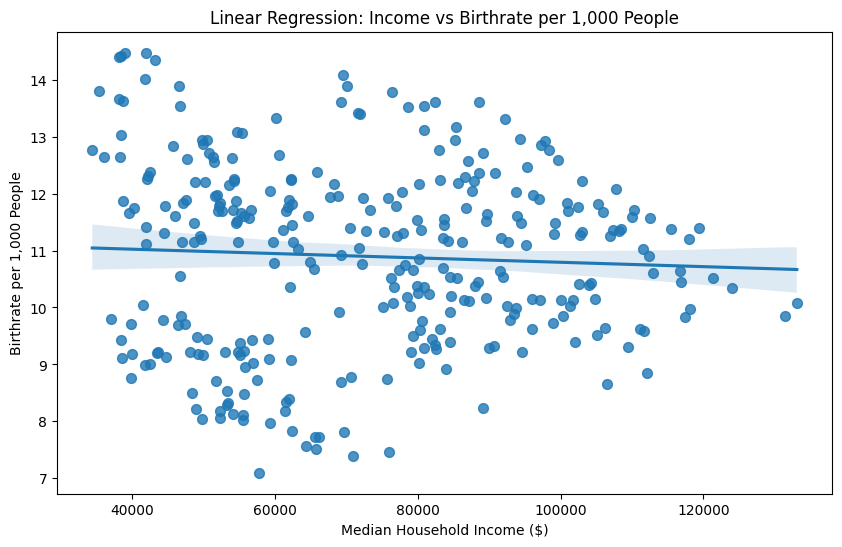

In [28]:
# Birth Rate Trends Per County
plt.figure(figsize=(10, 6))
sb.regplot(data=annual_income_and_birthrate, x="Median Income", y="Annual Birth Rate Per 1000", scatter_kws={'s': 50})
plt.xlabel('Median Household Income ($)')
plt.ylabel('Birthrate per 1,000 People')
plt.title('Linear Regression: Income vs Birthrate per 1,000 People')
plt.show()

In the graph above "Correlation Betwen Income and Birthrate by County (2010 - 2022)", we observe that there is no single trend line that all Maryland Counties follow. Thus, if given the state medians for household incomes and birth rate (per 1000), it would be impossible to generate predictions for each county's birth rate and household income. This result can be contributed to the different population densities and sizes of each county. For example, Fredrick County has a land area of 660.22 sq. miles. Conversely, Baltimore City has a land area of 80.94 sq. miles.  

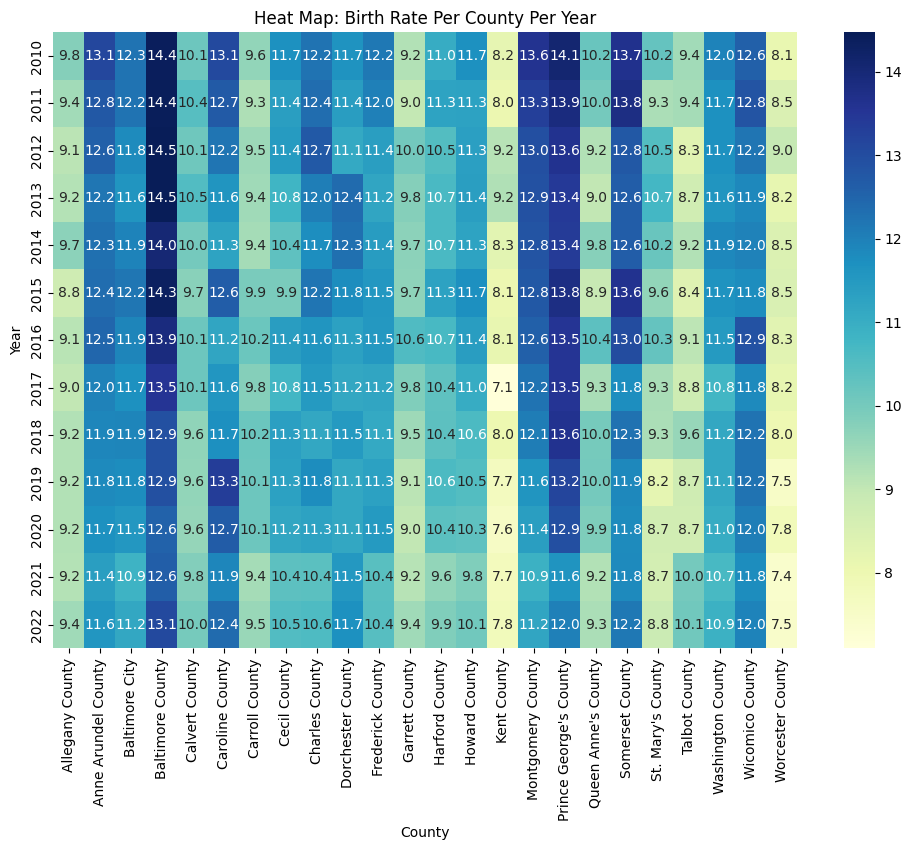

In [29]:
# # Heat Map Representation of Birth Rate by County and Year
plt.figure(figsize=(12, 8))
pivot_data = annual_income_and_birthrate.pivot(index='Year', columns='County', values='Annual Birth Rate Per 1000')
sb.heatmap(pivot_data, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Heat Map: Birth Rate Per County Per Year')
plt.show()

/var/folders/t0/0zppdrmj4w51x3479k76hvq40000gn/T/ipykernel_25002/3112643632.py:3: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sb.pointplot(data=annual_income_and_birthrate, x= 'Year', y='Annual Birth Rate Per 1000', join=False, estimator='mean', color='white')


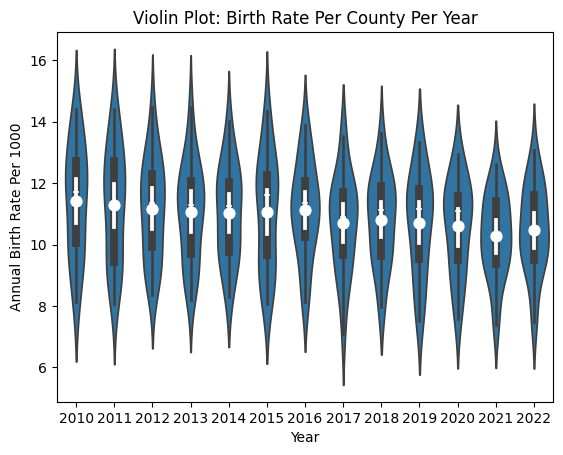

In [30]:
# Data Visualized as Violit Plot: Year vs Birth Rate
sb.violinplot(annual_income_and_birthrate, x= 'Year', y= 'Annual Birth Rate Per 1000' )
sb.pointplot(data=annual_income_and_birthrate, x= 'Year', y='Annual Birth Rate Per 1000', join=False, estimator='mean', color='white')
plt.title('Violin Plot: Birth Rate Per County Per Year')
plt.show()

## Hypothesis Testing

### Explanation

At this part of the project, we 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9320
Date:                Sat, 18 May 2024   Prob (F-statistic):              0.335
Time:                        22:22:26   Log-Likelihood:                -588.93
No. Observations:                 312   AIC:                             1182.
Df Residuals:                     310   BIC:                             1189.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1767      0.303     36.905      0.0

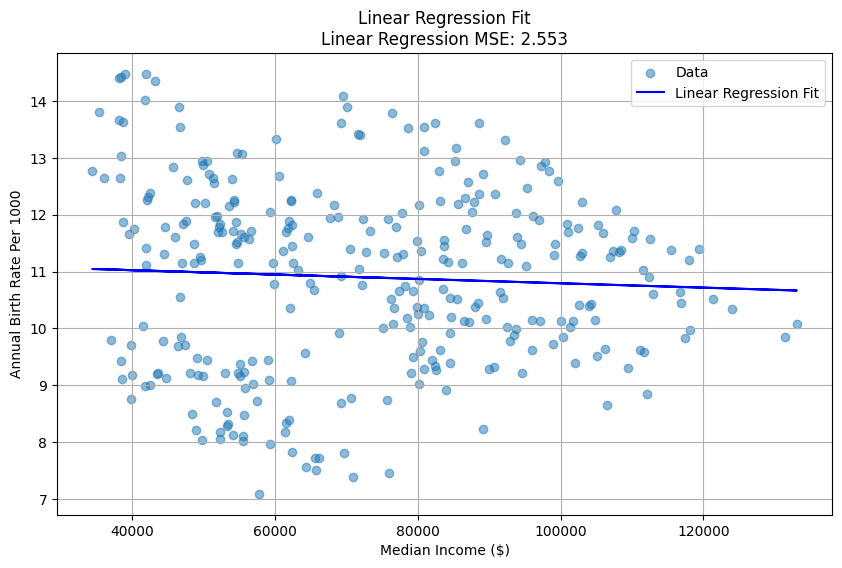

In [31]:
# Explain how this has rly bad p value because the data is not necesarry linear as a whole data set. 

X = annual_income_and_birthrate["Median Income"].values
y = annual_income_and_birthrate["Annual Birth Rate Per 1000"].values

# Add a constant to the independent variable (required for statsmodels regression)
X_with_const = smf.add_constant(X)

# Fit the linear regression model
model = smf.OLS(y, X_with_const).fit()

# Print the summary of the regression model
print(model.summary())

# Predict the values
linreg_y_pred = model.predict(X_with_const)

# Calculate the MSE
linreg_mse = mean_squared_error(y, linreg_y_pred)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, label='Data')
plt.plot(X, linreg_y_pred, color='blue', label='Linear Regression Fit')
plt.xlabel('Median Income ($)')
plt.ylabel('Annual Birth Rate Per 1000')
plt.title('Linear Regression Fit\nLinear Regression MSE: {:.3f}'.format(linreg_mse))
plt.legend()
plt.grid(True)
plt.show()


/var/folders/t0/0zppdrmj4w51x3479k76hvq40000gn/T/ipykernel_25002/3970115467.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = model.pvalues[0]  # Get the p-value for the slope
/var/folders/t0/0zppdrmj4w51x3479k76hvq40000gn/T/ipykernel_25002/3970115467.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefficient = model.params[0]  # Get the coefficient for the slope
/var/folders/t0/0zppdrmj4w51x3479k76hvq40000gn/T/ipykernel_25002/3970115467.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent w

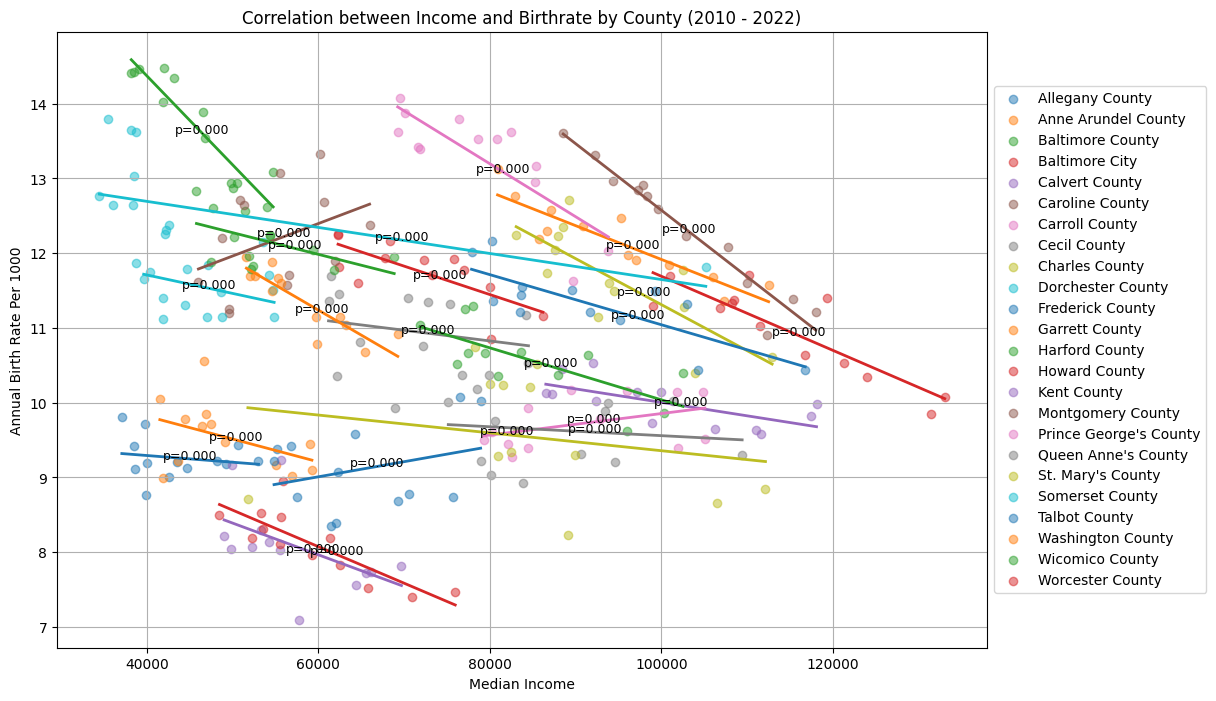

In [35]:
# Although we cant get a good linear regression line from teh whole data, we can see that each county's line is kinda linear. 

counties = annual_income_and_birthrate['County'].unique()

# Initialize a list to store p-values, coefficients, and MSEs
results = []

plt.figure(figsize=(12, 8))

# Plot for each county
for county in counties:
    county_data = annual_income_and_birthrate[annual_income_and_birthrate['County'] == county]
    
    # Scatter plot for the county
    plt.scatter(county_data['Median Income'], county_data['Annual Birth Rate Per 1000'], alpha= 0.5, label= f'{county}')
    
    # Calculate slope using numpy
    m, b = np.polyfit(county_data['Median Income'], county_data['Annual Birth Rate Per 1000'], 1)
    
    # Generate x and y values for the linear regression line
    x_values = np.linspace(county_data['Median Income'].min(), county_data['Median Income'].max(), 100)
    y_values = m * x_values + b
    
    # Plot the regression line
    plt.plot(x_values, y_values, linewidth=2)
    
    # Calculate p-values and coefficients using statsmodels without adding a constant term
    X = county_data['Median Income']
    y = county_data['Annual Birth Rate Per 1000']
    model = smf.OLS(y, X).fit()
    p_value = model.pvalues[0]  # Get the p-value for the slope
    coefficient = model.params[0]  # Get the coefficient for the slope
    
    # Predict values and calculate MSE
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    
    # Annotate the p-value on the plot
    plt.text(x_values.mean(), y_values.mean(), f'p={p_value:.3f}', fontsize=9, color='black', ha='center')
    
    # Store the results
    results.append({
        'County': county,
        'Coefficient': coefficient,
        'P-value': p_value,
        'MSE': mse
    })

# Add titles and labels
plt.title('Correlation between Income and Birthrate by County (2010 - 2022)')
plt.xlabel('Median Income')
plt.ylabel('Annual Birth Rate Per 1000')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.grid(True)
plt.show()

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

In [38]:
# Print the results
print(results_df.head())

# Highlight significant results
significant_results = results_df[results_df['P-value'] < 0.05]
print("\nSignificant results:")
print(significant_results.head())

# Get descriptive statistics
desc_stats = annual_income_and_birthrate.groupby('County')[['Median Income', 'Annual Birth Rate Per 1000']].describe().head()
print(desc_stats)

# Get sample size for each county
sample_sizes = annual_income_and_birthrate['County'].value_counts()
print(sample_sizes)

                County  Coefficient       P-value       MSE
0      Allegany County     0.000210  2.594868e-12  1.288683
1  Anne Arundel County     0.000127  1.023917e-11  2.794369
2     Baltimore County     0.000292  1.476101e-10  5.508969
3       Baltimore City     0.000162  5.585353e-12  2.361227
4       Calvert County     0.000098  4.679428e-12  1.655388

Significant results:
                County  Coefficient       P-value       MSE
0      Allegany County     0.000210  2.594868e-12  1.288683
1  Anne Arundel County     0.000127  1.023917e-11  2.794369
2     Baltimore County     0.000292  1.476101e-10  5.508969
3       Baltimore City     0.000162  5.585353e-12  2.361227
4       Calvert County     0.000098  4.679428e-12  1.655388
                       Median Income                                        \
                               count           mean           std      min   
County                                                                       
Allegany County         

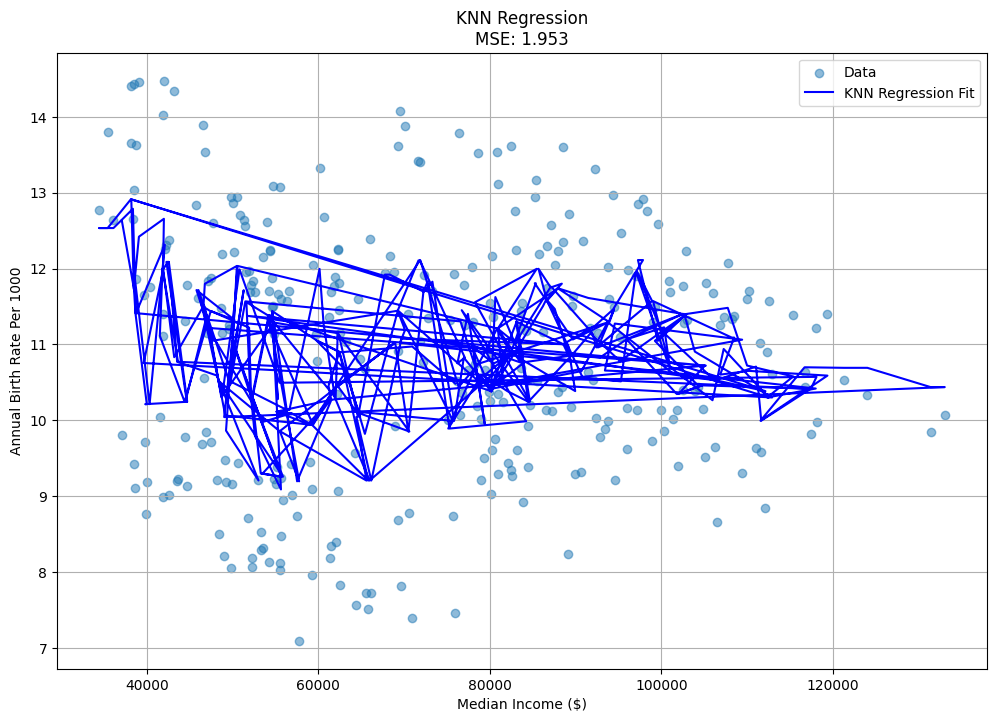

KNN Regression Mean Squared Error (MSE): 1.953


In [33]:
# Prepare the data
X = annual_income_and_birthrate['Median Income'].values.reshape(-1, 1)
y = annual_income_and_birthrate['Annual Birth Rate Per 1000'].values

knn_reg = KNeighborsRegressor(n_neighbors= 5)
knn_reg.fit(X, y)

# Predict values
KNN_y_pred = knn_reg.predict(X)

# Calculate MSE
knn_mse = mean_squared_error(y, KNN_y_pred)

# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(X, y, alpha=0.5, label='Data')
plt.plot(X, KNN_y_pred, color='blue', label='KNN Regression Fit')
plt.title('KNN Regression\nMSE: {:.3f}'.format(knn_mse))
plt.xlabel('Median Income ($)')
plt.ylabel('Annual Birth Rate Per 1000')
plt.legend()
plt.grid(True)
plt.show()

print(f"KNN Regression Mean Squared Error (MSE): {knn_mse:.3f}")


In [34]:
y_range = np.max(y) - np.min(y)
y_std = np.std(y)

print(f"Range of Annual Birth Rate Per 1000: {y_range}")
print(f"Standard Deviation of Annual Birth Rate Per 1000: {y_std}")


Range of Annual Birth Rate Per 1000: 7.37518181546673
Standard Deviation of Annual Birth Rate Per 1000: 1.60026012041026
